## Lesson 4: Applications of Embeddings

#### Project environment setup

- Load credentials and relevant Python Libraries

In [1]:
from utils import authenticate
credentials, PROJECT_ID = authenticate()

In [2]:
REGION = 'us-central1'

In [3]:
import vertexai
vertexai.init(project=PROJECT_ID, 
              location=REGION, 
              credentials = credentials)

#### Load Stack Overflow questions and answers from BigQuery
- BigQuery is Google Cloud's serverless data warehouse.
- We'll get the first 500 posts (questions and answers) for each programming language: Python, HTML, R, and CSS.

In [4]:
from google.cloud import bigquery
import pandas as pd

In [5]:
def run_bq_query(sql):

    # Create BQ client
    bq_client = bigquery.Client(project = PROJECT_ID, 
                                credentials = credentials)

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, 
                                         use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, 
                                    job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

In [6]:
# define list of programming language tags we want to query

language_list = ["python", "html", "r", "css"]

In [7]:
so_df = pd.DataFrame()

for language in language_list:
    
    print(f"generating {language} dataframe")
    
    query = f"""
    SELECT
        CONCAT(q.title, q.body) as input_text,
        a.body AS output_text
    FROM
        `bigquery-public-data.stackoverflow.posts_questions` q
    JOIN
        `bigquery-public-data.stackoverflow.posts_answers` a
    ON
        q.accepted_answer_id = a.id
    WHERE 
        q.accepted_answer_id IS NOT NULL AND 
        REGEXP_CONTAINS(q.tags, "{language}") AND
        a.creation_date >= "2020-01-01"
    LIMIT 
        500
    """

    
    language_df = run_bq_query(query)
    language_df["category"] = language
    so_df = pd.concat([so_df, language_df], 
                      ignore_index = True) 

generating python dataframe
Finished job_id: d914daf0-2f4d-46ce-a714-5b1f1a6f6f9f
generating html dataframe
Finished job_id: 1e94a188-22e8-469a-97c2-7e5f62a3479c
generating r dataframe
Finished job_id: 04a643b3-eb06-49c7-a825-d1e1f141e695
generating css dataframe
Finished job_id: c7bcff7a-819d-4a2e-aacc-d17848f41709


- You can reuse the above code to run your own queries if you are using Google Cloud's BigQuery service.
- In this classroom, if you run into any issues, you can load the same data from a csv file.

In [8]:
# Run this cell if you get any errors or you don't want to wait for the query to be completed
# so_df = pd.read_csv('so_database_app.csv')

In [9]:
so_df

,input_text,output_text,category
0,How can i slow animation speed and shouldn't d...,<p>One way to set the animation speed is throu...,python
1,Why am i getting a result for the components o...,"<p>Each time you call your function, two new r...",python
2,Upgrade python to 3.10 in windows; Do I have t...,<p>I upgraded to python 3.10.2 in windows 10 6...,python
3,TicTacToe game stuck in a while loop<p>I have ...,<p>There is a logical problem.</p>\n<p>The <co...,python
4,How to escape special characters in Python?<p>...,"<p>You can use the built-in function <a href=""...",python
...,...,...,...
1995,Change font based on language reactjs<p>I'm us...,<p>I am not very familiar with <code>i18next</...,css
1996,How can I set a default key javascript object?...,<p>It might be better to write a quick directi...,css
1997,how to add Tailwind CSS with PostCSS purge to ...,<p>It is possible to add tailwind to the Asset...,css
1998,How to make a div individually scrollable in R...,<p>Give the scrollable div <code>overflow-y: a...,css


#### Generate text embeddings
- To generate embeddings for a dataset of texts, we'll need to group the sentences together in batches and send batches of texts to the model.
- The API currently can take batches of up to 5 pieces of text per API call.

In [10]:
from vertexai.language_models import TextEmbeddingModel

In [11]:
model = TextEmbeddingModel.from_pretrained(
    "textembedding-gecko@001")

In [12]:
import time
import numpy as np

In [13]:
# Generator function to yield batches of sentences

def generate_batches(sentences, batch_size = 5):
    for i in range(0, len(sentences), batch_size):
        yield sentences[i : i + batch_size]

In [14]:
so_questions = so_df[0:200].input_text.tolist() 
batches = generate_batches(sentences = so_questions)

In [15]:
batch = next(batches)
len(batch)

5

#### Get embeddings on a batch of data
- This helper function calls `model.get_embeddings()` on the batch of data, and returns a list containing the embeddings for each text in that batch.

In [16]:
def encode_texts_to_embeddings(sentences):
    try:
        embeddings = model.get_embeddings(sentences)
        return [embedding.values for embedding in embeddings]
    except Exception:
        return [None for _ in range(len(sentences))]

In [17]:
batch_embeddings = encode_texts_to_embeddings(batch)

In [18]:
f"{len(batch_embeddings)} embeddings of size \
{len(batch_embeddings[0])}"

'5 embeddings of size 768'

#### Code for getting data on an entire data set
- Most API services have rate limits, so we've provided a helper function (in utils.py) that you could use to wait in-between API calls.
- If the code was not designed to wait in-between API calls, you may not receive embeddings for all batches of text.
- This particular service can handle 20 calls per minute.  In calls per second, that's 20 calls divided by 60 seconds, or `20/60`.

```Python
from utils import encode_text_to_embedding_batched

so_questions = so_df.input_text.tolist()
question_embeddings = encode_text_to_embedding_batched(
                            sentences=so_questions,
                            api_calls_per_second = 20/60, 
                            batch_size = 5)
```

In order to handle limits of this classroom environment, we're not going to run this code to embed all of the data. But you can adapt this code for your own projects and datasets.

#### Load the data from file
- We'll load the stack overflow questions, answers, and category labels (Python, HTML, R, CSS) from a .csv file.
- We'll load the embeddings of the questions (which we've precomputed with batched calls to `model.get_embeddings()`), from a pickle file.

In [19]:
so_df = pd.read_csv('so_database_app.csv')
so_df.head()

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python


In [20]:
import pickle

In [21]:
with open('question_embeddings_app.pkl', 'rb') as file:
    question_embeddings = pickle.load(file)

In [22]:
print("Shape: " + str(question_embeddings.shape))
print(question_embeddings)

Shape: (2000, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00580394 -0.01621097  0.05829635 ... -0.03350992 -0.05343556
  -0.06016821]
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]]


#### Cluster the embeddings of the Stack Overflow questions

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [24]:
clustering_dataset = question_embeddings[:1000]

In [25]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, 
                random_state=0, 
                n_init = 'auto').fit(clustering_dataset)

In [26]:
kmeans_labels = kmeans.labels_

In [27]:
PCA_model = PCA(n_components=2)
PCA_model.fit(clustering_dataset)
new_values = PCA_model.transform(clustering_dataset)

In [28]:
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl

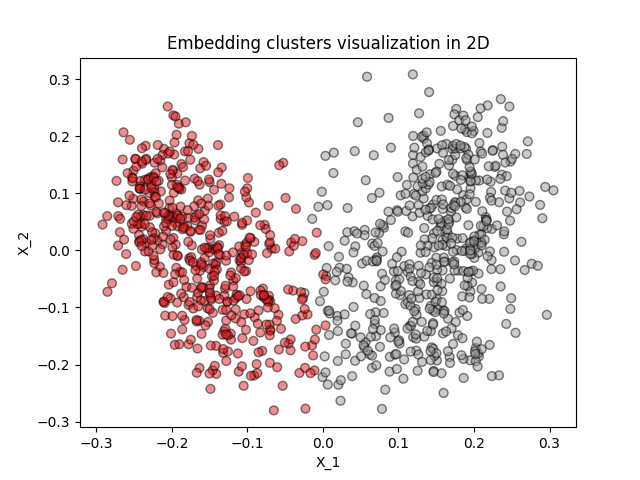

In [29]:
from utils import clusters_2D
clusters_2D(x_values = new_values[:,0], y_values = new_values[:,1], 
            labels = so_df[:1000], kmeans_labels = kmeans_labels)

- Clustering is able to identify two distinct clusters of HTML or Python related questions, without being given the category labels (HTML or Python).

## Anomaly / Outlier detection

- We can add an anomalous piece of text and check if the outlier (anomaly) detection algorithm (Isolation Forest) can identify it as an outlier (anomaly), based on its embedding.

In [30]:
from sklearn.ensemble import IsolationForest

In [31]:
input_text = """I am making cookies but don't 
                remember the correct ingredient proportions. 
                I have been unable to find 
                anything on the web."""

In [32]:
emb = model.get_embeddings([input_text])[0].values

In [33]:
embeddings_l = question_embeddings.tolist()
embeddings_l.append(emb)

In [34]:
embeddings_array = np.array(embeddings_l)

In [35]:
print("Shape: " + str(embeddings_array.shape))
print(embeddings_array)

Shape: (2001, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]
 [-0.00302366 -0.02049104  0.02172194 ... -0.04479321 -0.05254056
  -0.00319716]]


In [36]:
# Add the outlier text to the end of the stack overflow dataframe
so_df = pd.read_csv('so_database_app.csv')
new_row = pd.Series([input_text, None, "baking"], 
                    index=so_df.columns)
so_df.loc[len(so_df)+1] = new_row
so_df.tail()

,input_text,output_text,category
1996,Flip Clock code works on Codepen and doesn't w...,<p>You forgot to attach the CSS file for the f...,css
1997,React Native How can I put one view in front o...,<p>You can do it using zIndex for example:</p>...,css
1998,setting fixed width with 100% height of the pa...,<p>You can use <code>width: calc(100% - 100px)...,css
1999,How to make sidebar button not bring viewpoint...,"<p>It is quite simple, just remove that href=""...",css
2001,I am making cookies but don't \n ...,None,baking


#### Use Isolation Forest to identify potential outliers

- `IsolationForest` classifier will predict `-1` for potential outliers, and `1` for non-outliers.
- You can inspect the rows that were predicted to be potential outliers and verify that the question about baking is predicted to be an outlier.

In [37]:
clf = IsolationForest(contamination=0.005, 
                      random_state = 2) 

In [38]:
preds = clf.fit_predict(embeddings_array)

print(f"{len(preds)} predictions. Set of possible values: {set(preds)}")

2001 predictions. Set of possible values: {1, -1}


In [39]:
so_df.loc[preds == -1]

,input_text,output_text,category
203,extract channel names from a multi-channel ima...,<p>PerkinElmer QPI metadata are stored as XML ...,python
1018,ASP .NET - JSON Serializer not working on clas...,"<p>Ok, I forgot to add default <code>{ get; se...",r
1138,parse year and month from a string SQL BigQuer...,<p>How about using string operations?</p>\n<pr...,r
1313,Array initialization with ternary operator in ...,"<p>To make your code work, do the following in...",r
1358,How to represent 2 Entity with 2 Relation in E...,"<p><a href=""https://i.stack.imgur.com/BJxBP.pn...",r
1403,"Apache ignite Partition Map Exchange , Baselin...","<p>Long story short, these topics are about da...",r
1427,Shortcut to reveal in Finder for currently ope...,<p>No. It is not present but we can add it. Go...,r
1493,How to change id of datatable?<p>I have some w...,<p>In short - you can't. But maybe you can:</p...,r
1498,What’s the difference between Next.js rewrites...,<p><code>rewrites</code> are a convenient way ...,r
2001,I am making cookies but don't \n ...,None,baking


#### Remove the outlier about baking

In [40]:
so_df = so_df.drop(so_df.index[-1])

In [41]:
so_df

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python
...,...,...,...
1995,Is it possible to made inline-block elements l...,<p>If this is only for the visual purpose then...,css
1996,Flip Clock code works on Codepen and doesn't w...,<p>You forgot to attach the CSS file for the f...,css
1997,React Native How can I put one view in front o...,<p>You can do it using zIndex for example:</p>...,css
1998,setting fixed width with 100% height of the pa...,<p>You can use <code>width: calc(100% - 100px)...,css


## Classification
- Train a random forest model to classify the category of a Stack Overflow question (as either Python, R, HTML or CSS).

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [44]:
# re-load the dataset from file
so_df = pd.read_csv('so_database_app.csv')
X = question_embeddings
X.shape

(2000, 768)

In [45]:
y = so_df['category'].values
y.shape

(2000,)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 2)

In [47]:
clf = RandomForestClassifier(n_estimators=200)

In [48]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

#### You can check the predictions on a few questions from the test set

In [49]:
y_pred = clf.predict(X_test)

In [50]:
accuracy = accuracy_score(y_test, y_pred) # compute accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6925


#### Try out the classifier on some questions

In [51]:
# choose a number between 0 and 1999
i = 2
label = so_df.loc[i,'category']
question = so_df.loc[i,'input_text']

# get the embedding of this question and predict its category
question_embedding = model.get_embeddings([question])[0].values
pred = clf.predict([question_embedding])

print(f"For question {i}, the prediction is `{pred[0]}`")
print(f"The actual label is `{label}`")
print("The question text is:")
print("-"*50)
print(question)

For question 2, the prediction is `python`
The actual label is `python`
The question text is:
--------------------------------------------------
How do we test a specific method written in a list of files for functional testing in python<p>The project has so many modules. There are functional test cases being written for almost every api written like for GET requests, POST requests and PUT requests. To test an individual file we use the syntact pytest tests/file_name.py
but I want to test a specific method in that file. Is there any way to test it like that??</p>
